import matplotlib.pyplot as plt
import nltk
import pandas as pd
# ^^^ pyforest auto-imports - don't write above this line
# Imports

In [1]:
# pip install dwave_networkx

In [2]:
# pip install --upgrade networkx

In [3]:
import folium
from collections import Counter
import postman_problems
from postman_problems.solver import cpp
from postman_problems.stats import calculate_postman_solution_stats
import networkx as nx
import itertools
import dwave_networkx as dnx
import dimod
import time

## His Data

In [4]:
sleeping_edgelist = pd.read_csv("/Users/gregfeliu/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/postman_problems/examples/sleeping_giant/edgelist_sleeping_giant.csv")

<IPython.core.display.Javascript object>

In [5]:
seven_bridges_edgelist = pd.read_csv('./examples/edgelist_seven_bridges.csv')

<IPython.core.display.Javascript object>

## My Data

In [6]:
stations_df = pd.read_csv("./saved_data/final_station_df.csv", index_col = 0)

<IPython.core.display.Javascript object>

In [7]:
non_unique_stations_df = pd.read_csv("./saved_data/non_unique_mta_stations.csv", index_col=0)

<IPython.core.display.Javascript object>

In [8]:
my_edgelist = pd.read_csv('./saved_data/edge_list_df_no_req.csv', index_col=0)

<IPython.core.display.Javascript object>

In [9]:
my_edgelist['trail'] = 'nyc'

In [10]:
node_list_df = pd.read_csv("./saved_data/nodelist_nyc_subway.csv", index_col=0)

<IPython.core.display.Javascript object>

In [11]:
node_list_df.reset_index(inplace=True)

### Which nodes in edgelist are different from nodelist?... None (now)

In [12]:
node1 = list(my_edgelist['node1'].unique())
node2 = list(my_edgelist['node2'].unique())
len(set(node1 + node2))

451

In [13]:
node_list_df.shape

(452, 3)

In [14]:
node_list_df.station_id.nunique()

452

In [15]:
node_list_df.columns

Index(['station_id', 'X', 'Y'], dtype='object')

In [16]:
for x in node_list_df['station_id']:
    if len(x) > 4:
        print(x)

112_A09
125_A24
127_R16
140_142
222_415
414_D11
631_723_901
635_L03_R20
710_G14
718_R09
127_725_902_R16
A12_D13
L01_A31
A32_D20
A38_M22
D17_R17
D43_N12
M12_G31
H01_H02
H04_H19
L22_J27
L17_M08
M20_Q01


In [17]:
for x in my_edgelist['node1']:
    if 'A13' in x:
        print(x)

In [18]:
edgelist_nodes = set(node1 + node2)

In [19]:
nodelist_nodes = set(node_list_df['station_id'].unique())

In [20]:
edgelist_nodes - nodelist_nodes

set()

In [21]:
nodelist_nodes - edgelist_nodes

{'127_R16'}

# Example

In [22]:
# # find CPP solution
# circuit, graph = cpp(edgelist_filename='./examples/edgelist_seven_bridges.csv', start_node='D')

# # print solution route
# for e in circuit:
#     print(e)

# # print solution summary stats
# for k, v in calculate_postman_solution_stats(circuit).items():
#     print(k, v)

# Applied to my data

## Visualize nodes

In [23]:
g = nx.Graph()

In [24]:
for i, elrow in my_edgelist.iterrows():
    # g.add_edge(elrow[0], elrow[1], attr_dict=elrow[2:].to_dict())  # deprecated after NX 1.11
    g.add_edge(elrow[0], elrow[1], **elrow[2:].to_dict())

In [25]:
for i, nlrow in node_list_df.iterrows():
    nx.set_node_attributes(g, {nlrow['station_id']:  nlrow[1:].to_dict()})  

In [26]:
print('# of edges: {}'.format(g.number_of_edges()))
print('# of nodes: {}'.format(g.number_of_nodes()))

# of edges: 544
# of nodes: 451


In [27]:
list(g.nodes(data=True))[0:5] 

[('101', {'X': 40.889248, 'Y': -73.898583}),
 ('103', {'X': 40.884667, 'Y': -73.90087}),
 ('104', {'X': 40.878856, 'Y': -73.904834}),
 ('106', {'X': 40.874561, 'Y': -73.90983100000003}),
 ('107', {'X': 40.869444, 'Y': -73.915279})]

In [28]:
# for x in list(g.nodes(data=True)):
#     print(x[1]['Y'])
node_positions_as_dict = {x[0]: x[1] for x in list(g.nodes(data=True))}

In [29]:
node_positions_final = {key: value for key, value in node_positions_as_dict.items()}

In [30]:
node_positions_final['101']['X']

40.889248

In [31]:
test_node_positions = {node[0]: (node[1]) for node in g.nodes(data=True)}

### Checking for stops without coords

In [32]:
for key, value in test_node_positions.items():
    if value == {}:
        print(key)    

In [33]:
test_node_positions['A03']

{'X': 40.865491, 'Y': -73.92727099999998}

In [34]:
# test_node_positions

In [35]:
node_positions = {node[0]: (node[1]['Y'], node[1]['X']) for node in list(g.nodes(data=True))}
# dict(list(node_positions.items())[0:5])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

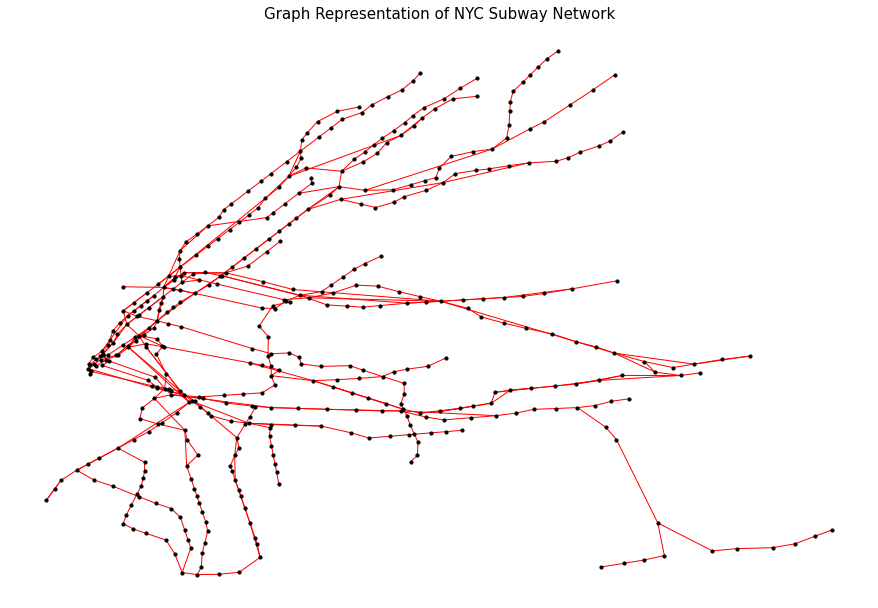

In [62]:
plt.figure(figsize=(12, 8))
nx.draw(g, pos=node_positions, edge_color='red', node_size=10, node_color='black')
plt.title('Graph Representation of NYC Subway Network', size=15)
plt.show()

## Solve Problem

In [37]:
nodes_odd_degree = [v for v, d in g.degree() if d % 2 == 1]
nodes_odd_degree[0:5]

['101', '112_A09', '127_725_902_R16', '125_A24', '128']

In [38]:
print('Number of nodes of odd degree: {}'.format(len(nodes_odd_degree)))
print('Number of total nodes: {}'.format(len(g.nodes())))

Number of nodes of odd degree: 80
Number of total nodes: 451


In [39]:
# Compute all pairs of odd nodes. in a list of tuples
odd_node_pairs = list(itertools.combinations(nodes_odd_degree, 2))
# Preview pairs of odd degree nodes
odd_node_pairs[0:3]

[('101', '112_A09'), ('101', '127_725_902_R16'), ('101', '125_A24')]

In [40]:
print('Number of pairs: {}'.format(len(odd_node_pairs)))

Number of pairs: 3160


In [41]:
def get_shortest_paths_distances(graph, pairs, edge_weight_name):
    """Compute shortest distance between each pair of nodes in a graph.  Return a dictionary keyed on node pairs (tuples)."""
    distances = {}
    for pair in pairs:
        distances[pair] = nx.dijkstra_path_length(graph, pair[0], pair[1], weight=edge_weight_name)
    return distances

In [42]:
odd_node_pairs_shortest_paths = get_shortest_paths_distances(g, odd_node_pairs, 'distance')
# Preview with a bit of hack (there is no head/slice method for dictionaries).
dict(list(odd_node_pairs_shortest_paths.items())[0:10])

{('101', '112_A09'): 810,
 ('101', '127_725_902_R16'): 1920,
 ('101', '125_A24'): 1710,
 ('101', '128'): 2010,
 ('101', '140_142'): 2910,
 ('101', '201'): 3150,
 ('101', '221'): 1530,
 ('101', '222_415'): 1410,
 ('101', '224'): 1710,
 ('101', '234'): 3060}

In [43]:
# find CPP solution
# circuit, graph = cpp(edgelist_filename='./saved_data/edge_list_df_no_req.csv', start_node = '101', verbose=True)

# Mini Networkx Attempt

## Getting A,C,E Edges

In [106]:
good_indices_ace = []
for idx, x in enumerate(my_edgelist['node1']):
    for letter in ['A', "C", 'E']:
        if letter in x and letter in my_edgelist['node2'][idx]:
            if idx not in good_indices_ace:
                good_indices_ace.append(idx)

In [107]:
ACE_edgelist = my_edgelist.iloc[good_indices_ace]

In [108]:
ACE_edgelist.head(2)

,node1,node2,trail,color,distance
194,A02,A03,nyc,red,90
195,A03,A05,nyc,red,120


In [119]:
ACE_edgelist.reset_index(inplace=True, drop=True)

In [123]:
ACE_edgelist[ACE_edgelist['node1'] == '112_A09']

,node1,node2,trail,color,distance
5,112_A09,A12_D13,nyc,red,210
6,112_A09,A10,nyc,red,90


## Getting A,C,E Nodes

In [109]:
A_nodelist = node_list_df[node_list_df.station_id.str.contains("A")]
C_nodelist = node_list_df[node_list_df.station_id.str.contains("C")]
E_nodelist = node_list_df[node_list_df.station_id.str.contains("E")]
ACE_nodelist = pd.concat([A_nodelist, C_nodelist, E_nodelist])

<IPython.core.display.Javascript object>

In [110]:
ACE_nodelist.shape

(53, 3)

In [125]:
ACE_nodelist

,station_id,X,Y
9,112_A09,40.840556,-73.940133
22,125_A24,40.768247,-73.981929
174,A02,40.868072,-73.919899
175,A03,40.865491,-73.927271
176,A05,40.859022,-73.934180
177,A06,40.851695,-73.937969
178,A07,40.847391,-73.939704
179,A10,40.836013,-73.939892
180,A11,40.830518,-73.941514
181,A12_D13,40.824783,-73.944216


## Creating Graph

In [193]:
mini_g = nx.MultiGraph()

### Adding nodes the networkx way

In [194]:
mini_g.add_nodes_from(ACE_nodelist['station_id'])

In [195]:
mini_g.nodes()

NodeView(('112_A09', '125_A24', 'A02', 'A03', 'A05', 'A06', 'A07', 'A10', 'A11', 'A12_D13', 'A14', 'A15', 'A16', 'A17', 'A18', 'A19', 'A20', 'A21', 'A22', 'A25', 'A27', 'A28', 'A30', 'L01_A31', 'A32_D20', 'A33', 'A34', 'A36', 'A38_M22', 'A40', 'A41', 'A42', 'A43', 'A44', 'A45', 'A46', 'A47', 'A48', 'A49', 'A50', 'A51', 'A52', 'A53', 'A54', 'A55', 'A57', 'A59', 'A60', 'A61', 'A63', 'A64', 'A65', 'E01'))

In [196]:
for idx, x in enumerate(list(zip(ACE_edgelist['node1'], ACE_edgelist['node2'], ACE_edgelist['distance']))):
    weight1 = ACE_edgelist['distance'][idx]
    mini_g.add_edge(x[0], x[1], weight=weight1)

In [201]:
mini_g.edges(['112_A09'])

MultiEdgeDataView([('112_A09', 'A07'), ('112_A09', 'A12_D13'), ('112_A09', 'A10')])

### Testing Graph

In [202]:
complete_mini_g = nx.complete_graph(mini_g)

In [204]:
complete_mini_g.edges(['112_A09'])

EdgeDataView([('112_A09', '125_A24'), ('112_A09', 'A02'), ('112_A09', 'A03'), ('112_A09', 'A05'), ('112_A09', 'A06'), ('112_A09', 'A07'), ('112_A09', 'A10'), ('112_A09', 'A11'), ('112_A09', 'A12_D13'), ('112_A09', 'A14'), ('112_A09', 'A15'), ('112_A09', 'A16'), ('112_A09', 'A17'), ('112_A09', 'A18'), ('112_A09', 'A19'), ('112_A09', 'A20'), ('112_A09', 'A21'), ('112_A09', 'A22'), ('112_A09', 'A25'), ('112_A09', 'A27'), ('112_A09', 'A28'), ('112_A09', 'A30'), ('112_A09', 'L01_A31'), ('112_A09', 'A32_D20'), ('112_A09', 'A33'), ('112_A09', 'A34'), ('112_A09', 'A36'), ('112_A09', 'A38_M22'), ('112_A09', 'A40'), ('112_A09', 'A41'), ('112_A09', 'A42'), ('112_A09', 'A43'), ('112_A09', 'A44'), ('112_A09', 'A45'), ('112_A09', 'A46'), ('112_A09', 'A47'), ('112_A09', 'A48'), ('112_A09', 'A49'), ('112_A09', 'A50'), ('112_A09', 'A51'), ('112_A09', 'A52'), ('112_A09', 'A53'), ('112_A09', 'A54'), ('112_A09', 'A55'), ('112_A09', 'A57'), ('112_A09', 'A59'), ('112_A09', 'A60'), ('112_A09', 'A61'), ('112_

In [203]:
print(nx.is_connected(complete_mini_g))

True


In [98]:
[len(c) for c in sorted(nx.connected_components(complete_mini_g), key=len, reverse=True)]

[106]

In [99]:
mini_g.get_edge_data('A02', 'A03', default=None)

In [205]:
#  dict(mini_g.nodes(data='weight', default=1))

## Solving Mini Graph

In [206]:
nx_solution1 = dnx.traveling_salesperson_qubo(mini_g, weight='weight')

ValueError: graph must be a complete graph with at least 3 nodes or empty

# Attempt using Networkx

In [44]:
complete_g = nx.complete_graph(g)

In [45]:
print(nx.is_connected(complete_g))

True


In [46]:
[len(c) for c in sorted(nx.connected_components(complete_g), key=len, reverse=True)]

[451]

In [47]:
nx.number_connected_components(complete_g)

1

In [48]:
# no "island" nodes
[len(c) for c in sorted(nx.isolates(complete_g), key=len, reverse=True)]

[]

In [49]:
chain_decomp = [len(c) for c in sorted(nx.algorithms.chains.chain_decomposition(complete_g), key=len, reverse=True)]
one_chain = [x for x in chain_decomp if x == 1]

In [50]:
# https://stackoverflow.com/questions/20012579/is-there-an-easy-way-to-prune-disconnected-networks-in-a-networkx-graph
# Generate connected components and select the largest:
largest_component = max(nx.connected_components(complete_g), key=len)
# Create a subgraph of G consisting only of this component:
g2 = complete_g.subgraph(largest_component)

In [51]:
len(largest_component)

451

In [52]:
# min(nx.connected_components(g), key=len)

In [53]:
all_connected_components = list(nx.connected_components(complete_g))

In [55]:
len(all_connected_components)

1

In [56]:
len(non_unique_stations_df) - len(node_list_df)

25

## TSP

In [57]:
# nx_solution = dnx.traveling_salesperson(complete_g, sampler=dimod.ExactSolver())

In [58]:
time.localtime()

time.struct_time(tm_year=2020, tm_mon=7, tm_mday=25, tm_hour=12, tm_min=25, tm_sec=19, tm_wday=5, tm_yday=207, tm_isdst=1)

In [59]:
nx_solution1 = dnx.traveling_salesperson_qubo(complete_g)
time.localtime()

KeyboardInterrupt: 

# Attempt using Dijkstar